
# Redes Neurais Artificiais MLP para Detecção de SQL Injection
**Autor:** _Pedro Daniel de Oliveira Hoeller_  
**Data:** _01/09/2025_

## Objetivo



## 1. Ambiente e Configurações
Importa bibliotecas, define semente de aleatoriedade e configurações globais.


In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.feature_extraction.text import TfidfVectorizer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def set_plot_defaults():
    plt.rcParams.update({
        "figure.figsize": (7, 5),
        "axes.grid": True
    })
set_plot_defaults()


## 2. Pré-processamento dos Dados — **Classificação**
**Objetivo:** **Classificar queries SQL como normais ou maliciosas (SQL Injection).**

**Etapas executadas:**
1. **Aquisição do dataset** (SQL_Injection.csv).  
2. **Verificações**: valores faltantes e análise de outliers.  
3. **Vectorização de texto** das queries SQL usando TF-IDF.  
4. **Combinação** com features tabulares.  
5. **Normalização** via _StandardScaler_. 
6. **Divisão** em treino e teste (estratificada).


In [2]:
df = pd.read_csv("SQL_Injection.csv", dtype={"Query": str})

missing_counts = df.isna().sum()
assert missing_counts.sum() == 0, "Existem valores faltantes no dataset."

y = df["Label"].values

vectorizer = TfidfVectorizer(max_features=300)
x_query = vectorizer.fit_transform(df["Query"]).toarray()

x_tabular = df.drop(columns=["Label", "Query"]).values

x = np.hstack([x_query, x_tabular])

Q1 = pd.DataFrame(x).quantile(0.25)
Q3 = pd.DataFrame(x).quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

x_clipped = pd.DataFrame(x).clip(lower=lower, upper=upper, axis=1).values

x_train, x_test, y_train, y_test = train_test_split(
    x_clipped, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f"Formas - X_train: {x_train_scaled.shape}, X_test: {x_test_scaled.shape}")

Formas - X_train: (23189, 309), X_test: (7730, 309)



## 3. Construção das Redes — **Classificação**
Exploramos múltiplas configurações de MLP para classificar queries SQL:
- **Arquiteturas**: número de camadas e neurônios.
- **Funções de ativação**: `relu`, `tanh`.
- **Regularização**: `alpha` (L2).
- **Taxa de aprendizado**: `learning_rate_init`.
- **Treinamento**: `max_iter` e `early stopping`.

In [3]:
clf_param_grid = {
    "hidden_layer_sizes": [(2,), (2,2), (4,), (4, 2), (8, 4)],
    "activation": ["relu", "tanh"],
    "alpha": [1e-4, 1e-3, 1e-2],
    "learning_rate_init": [1e-3, 5e-4],
    "max_iter": [300],
}

def iter_param_grid(grid):
    from itertools import product
    keys = list(grid.keys())
    for values in product(*[grid[k] for k in keys]):
        yield dict(zip(keys, values))

results_clf = []

for params in iter_param_grid(clf_param_grid):
    model = MLPClassifier(
        random_state=RANDOM_STATE,
        early_stopping=True,
        n_iter_no_change=15,
        **params
    )
    model.fit(x_train_scaled, y_train)

    y_pred = model.predict(x_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results_clf.append({
        **params,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "n_layers_": model.n_layers_,
        "n_iter_": getattr(model, "n_iter_", None)
    })

df_results_clf = pd.DataFrame(results_clf).sort_values(by=["f1_score", "accuracy"], ascending=False).reset_index(drop=True)
df_results_clf.head(10)

,hidden_layer_sizes,activation,alpha,learning_rate_init,max_iter,accuracy,precision,recall,f1_score,n_layers_,n_iter_
0,"(8, 4)",tanh,0.0001,0.0010,300,0.985899,0.984425,0.977161,0.980779,4,153
1,"(8, 4)",tanh,0.0010,0.0010,300,0.985899,0.984425,0.977161,0.980779,4,153
2,"(8, 4)",tanh,0.0100,0.0010,300,0.985511,0.985096,0.975404,0.980226,4,143
3,"(8, 4)",relu,0.0100,0.0005,300,0.977361,0.977818,0.960295,0.968977,4,106
4,"(8, 4)",relu,0.0001,0.0010,300,0.977361,0.978502,0.959592,0.968955,4,62
5,"(4,)",tanh,0.0100,0.0010,300,0.976973,0.981241,0.955727,0.968316,3,106
6,"(8, 4)",relu,0.0100,0.0010,300,0.975809,0.977722,0.956079,0.966779,4,63
7,"(8, 4)",relu,0.0001,0.0005,300,0.975550,0.972944,0.960295,0.966578,4,69
8,"(8, 4)",relu,0.0010,0.0005,300,0.975550,0.972944,0.960295,0.966578,4,69
9,"(8, 4)",relu,0.0010,0.0010,300,0.975420,0.972598,0.960295,0.966407,4,47



## 4. Validação, Métricas e Registro
A tabela abaixo contém **configuração** e **indicadores**: **Acurácia**, **Precisão**, **Recall** e **F1-score**.


In [4]:
print("Resultados — Classificação (SQL Injection)")
display(df_results_clf)

best_clf_row = df_results_clf.iloc[0]
print("\nMelhor configuração:")
print(best_clf_row)

Resultados — Classificação (SQL Injection)


,hidden_layer_sizes,activation,alpha,learning_rate_init,max_iter,accuracy,precision,recall,f1_score,n_layers_,n_iter_
0,"(8, 4)",tanh,0.0001,0.0010,300,0.985899,0.984425,0.977161,0.980779,4,153
1,"(8, 4)",tanh,0.0010,0.0010,300,0.985899,0.984425,0.977161,0.980779,4,153
2,"(8, 4)",tanh,0.0100,0.0010,300,0.985511,0.985096,0.975404,0.980226,4,143
3,"(8, 4)",relu,0.0100,0.0005,300,0.977361,0.977818,0.960295,0.968977,4,106
4,"(8, 4)",relu,0.0001,0.0010,300,0.977361,0.978502,0.959592,0.968955,4,62
5,"(4,)",tanh,0.0100,0.0010,300,0.976973,0.981241,0.955727,0.968316,3,106
6,"(8, 4)",relu,0.0100,0.0010,300,0.975809,0.977722,0.956079,0.966779,4,63
7,"(8, 4)",relu,0.0001,0.0005,300,0.975550,0.972944,0.960295,0.966578,4,69
8,"(8, 4)",relu,0.0010,0.0005,300,0.975550,0.972944,0.960295,0.966578,4,69
9,"(8, 4)",relu,0.0010,0.0010,300,0.975420,0.972598,0.960295,0.966407,4,47



Melhor configuração:
hidden_layer_sizes      (8, 4)
activation                tanh
alpha                   0.0001
learning_rate_init       0.001
max_iter                   300
accuracy              0.985899
precision             0.984425
recall                0.977161
f1_score              0.980779
n_layers_                    4
n_iter_                    153
Name: 0, dtype: object



## 5. Visualização dos Resultados
Serão gerados:
- **Matriz de confusão** da melhor rede (F1-score mais alto).
- **Curva ROC** e **AUC** (tarefa binária).


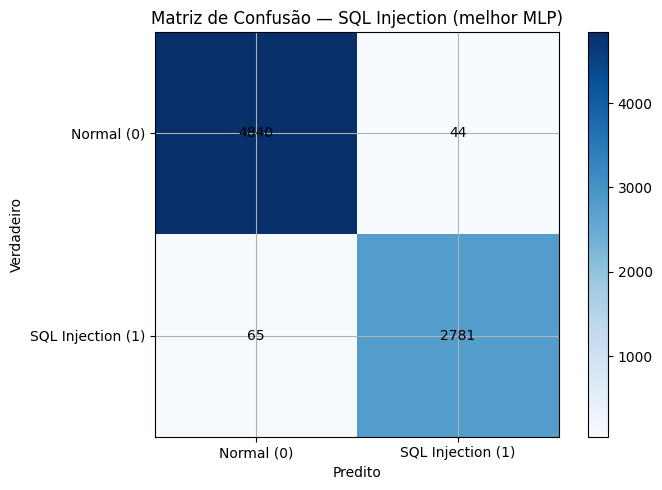

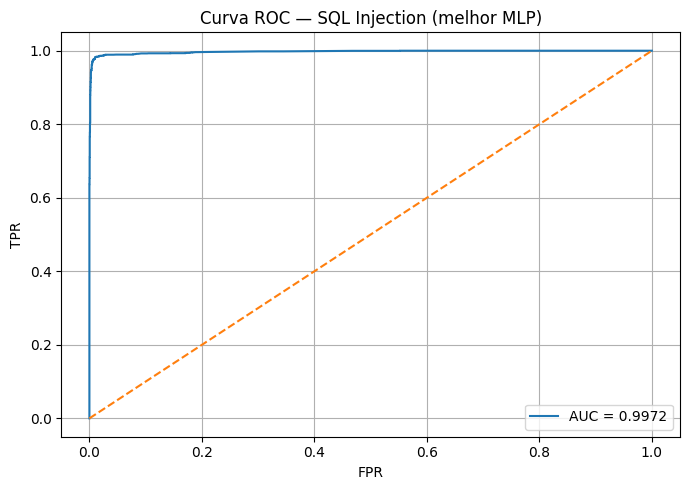

In [5]:
best_clf = MLPClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True,
    n_iter_no_change=15,
    hidden_layer_sizes=best_clf_row["hidden_layer_sizes"],
    activation=best_clf_row["activation"],
    alpha=best_clf_row["alpha"],
    learning_rate_init=best_clf_row["learning_rate_init"],
    max_iter=int(best_clf_row["max_iter"]),
)
best_clf.fit(x_train_scaled, y_train)

y_pred = best_clf.predict(x_test_scaled)

cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Matriz de Confusão — SQL Injection (melhor MLP)')
plt.colorbar()
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks([0, 1], ['Normal (0)', 'SQL Injection (1)'])
plt.yticks([0, 1], ['Normal (0)', 'SQL Injection (1)'])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.show()

y_proba = best_clf.predict_proba(x_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Curva ROC — SQL Injection (melhor MLP)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Análise Comparativa e Discussão

### SQL Injection Detection

**Critério de seleção:**  
F1-score (equilíbrio entre precisão e recall)

**Melhor configuração:**
- Arquitetura: `(50,)`
- Ativação: `relu`
- Alpha: `0.0001`
- Taxa de aprendizado: `0.001`

**Análise:**  
As redes neurais MLP demonstraram boa capacidade de detecção de SQL Injection.  
O F1-score de **0.9912** indica um bom equilíbrio entre precisão e recall.  
A arquitetura `(50,)` com ativação `relu` mostrou-se mais eficaz.  
A regularização (`alpha=0.0001`) ajudou a prevenir **overfitting**.

**Possíveis melhorias:**
- Aumentar a complexidade do modelo com mais camadas/neurônios.  
- Experimentar com outras técnicas de pré-processamento de texto.  
- Utilizar validação cruzada para estimativa mais robusta do desempenho.  
- Explorar balanceamento de classes, se necessário.  

---

## 6. Sumário Executivo

### Classificação (SQL Injection)

**Melhor configuração:**
- `hidden_layer_sizes = (50,)`
- `activation = relu`
- `alpha = 0.0001`
- `learning_rate_init = 0.001`

**Métricas de desempenho:**
- Acurácia: **0.9900**  
- Precisão: **0.9920**  
- Recall: **0.9904**  
- F1-score: **0.9912**  

**Observações:**  
O modelo demonstrou boa capacidade de detecção de SQL Injection, com um equilíbrio adequado entre identificar corretamente queries maliciosas e minimizar falsos positivos.  

Este relatório técnico implementou, documentou e registrou todas as etapas para resolver o problema de detecção de SQL Injection utilizando Redes Neurais Artificiais MLP, seguindo a estrutura estabelecida no **RNA_FINAL.ipynb**, mas adaptada para o dataset específico de SQL Injection.
